In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

In [6]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [7]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [45]:
import torch

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [10]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [11]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [ ]:
N[0]

In [ ]:
p = N[0].float()
p = p / p.sum()
p

In [ ]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

In [ ]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

In [ ]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

In [ ]:
P = (N+1).float()
P.sum(1, keepdim=True).shape
# 27, 27
# 27, 1
# if -> P.sum(1)
# 27, 27
#  1, 27
# Read Broadcasting semantics carefully

In [ ]:
P /= P.sum(1, keepdim=True)
P[0].sum()

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

In [ ]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [22]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
#         print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [23]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [24]:
xs

tensor([ 0,  5, 13, 13,  1])

In [25]:
ys

tensor([ 5, 13, 13,  1,  0])

In [26]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
xenc.shape

torch.Size([5, 27])

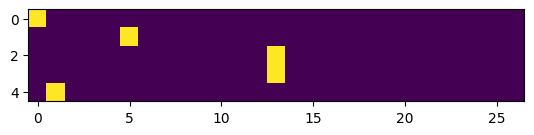

In [28]:
plt.imshow(xenc)

In [29]:
xenc.dtype

torch.float32

In [30]:
W = torch.randn(27, 27)
xenc @ W

tensor([[-0.3314, -0.0360,  0.5890,  1.2249,  0.3521,  0.7052, -0.8583,  1.2401,
          0.2342, -0.6076,  1.4227, -0.5254,  1.2863, -1.6728,  0.1197,  1.2534,
          0.7491, -0.0846, -1.6282, -0.2894, -1.8301, -0.5638, -0.7682,  1.0923,
          0.0352,  0.7077, -0.7846],
        [ 2.1972, -0.3812,  1.1394,  0.1763, -0.9948, -0.3881,  1.0069,  0.7953,
          1.8020,  0.5163, -0.1167,  0.9208, -1.8729, -0.8379,  0.4361,  0.4086,
          1.3472, -0.0965,  0.1187,  1.7156, -0.2756, -0.1920,  1.8113,  0.8685,
         -0.9996,  0.6414,  1.4550],
        [-1.4980,  0.7759,  1.0641, -0.0038, -0.8936, -2.0180, -0.5651,  1.4114,
         -0.4018, -0.0441, -0.5874,  1.9840, -1.1127,  1.4234,  0.7679,  0.4630,
         -2.3201,  0.7804,  1.0960, -1.4073,  2.7673,  1.2792,  1.2151,  2.8428,
          0.9015, -0.7016,  1.1631],
        [-1.4980,  0.7759,  1.0641, -0.0038, -0.8936, -2.0180, -0.5651,  1.4114,
         -0.4018, -0.0441, -0.5874,  1.9840, -1.1127,  1.4234,  0.7679,  0.4630

In [34]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0176, 0.0236, 0.0441, 0.0833, 0.0348, 0.0495, 0.0104, 0.0845, 0.0309,
         0.0133, 0.1015, 0.0145, 0.0885, 0.0046, 0.0276, 0.0857, 0.0517, 0.0225,
         0.0048, 0.0183, 0.0039, 0.0139, 0.0113, 0.0729, 0.0253, 0.0496, 0.0112],
        [0.1432, 0.0109, 0.0497, 0.0190, 0.0059, 0.0108, 0.0435, 0.0352, 0.0964,
         0.0267, 0.0142, 0.0400, 0.0024, 0.0069, 0.0246, 0.0239, 0.0612, 0.0144,
         0.0179, 0.0885, 0.0121, 0.0131, 0.0973, 0.0379, 0.0059, 0.0302, 0.0682],
        [0.0028, 0.0269, 0.0358, 0.0123, 0.0051, 0.0016, 0.0070, 0.0507, 0.0083,
         0.0118, 0.0069, 0.0899, 0.0041, 0.0513, 0.0266, 0.0196, 0.0012, 0.0270,
         0.0370, 0.0030, 0.1967, 0.0444, 0.0417, 0.2122, 0.0304, 0.0061, 0.0396],
        [0.0028, 0.0269, 0.0358, 0.0123, 0.0051, 0.0016, 0.0070, 0.0507, 0.0083,
         0.0118, 0.0069, 0.0899, 0.0041, 0.0513, 0.0266, 0.0196, 0.0012, 0.0270,
         0.0370, 0.0030, 0.1967, 0.0444, 0.0417, 0.2122, 0.0304, 0.0061, 0.0396],
        [0.1134, 0.0169,

In [36]:
probs.shape

torch.Size([5, 27])

In [35]:
probs[0].sum()

tensor(1.)

In [32]:
# (5, 27) @ (27, 27) -> (5, 27)

In [ ]:
# Optimization Test

In [37]:
xs

tensor([ 0,  5, 13, 13,  1])

In [38]:
ys

tensor([ 5, 13, 13,  1,  0])

In [52]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs.
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [63]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [64]:
print(loss.item())

3.7091336250305176


In [61]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [62]:
# update
W.data += -0.1 * W.grad

In [ ]:
# Optimization

In [68]:
# create the dataset

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [73]:
# gradient descent
for k in range(100):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    
    # update
    W.data += -50 * W.grad

2.4834256172180176
2.4833853244781494
2.4833481311798096
2.4833130836486816
2.483279228210449
2.4832475185394287
2.4832162857055664
2.4831864833831787
2.4831576347351074
2.4831297397613525
2.483102560043335
2.483076572418213
2.48305082321167
2.483025550842285
2.4830009937286377
2.4829771518707275
2.4829540252685547
2.482931137084961
2.4829089641571045
2.482887029647827
2.482865810394287
2.482844591140747
2.4828240871429443
2.4828040599823
2.4827840328216553
2.482764720916748
2.48274564743042
2.482726812362671
2.48270845413208
2.4826900959014893
2.4826722145080566
2.482654571533203
2.482637405395508
2.4826204776763916
2.4826035499572754
2.4825870990753174
2.4825704097747803
2.4825544357299805
2.4825387001037598
2.482522964477539
2.4825074672698975
2.482492446899414
2.4824771881103516
2.4824624061584473
2.482448101043701
2.4824330806732178
2.482419013977051
2.4824047088623047
2.4823906421661377
2.482377052307129
2.48236346244812
2.4823501110076904
2.4823367595672607
2.48232364654541
2.48

In [81]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)
for i in range(5):

    out = []
    ix = 0
    while True:
        
        # ----------
        # BEFORE:
#         p = P[ix]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
